In [1]:
## Importing the necessary packages
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/EE147

Mounted at /content/drive
/content/drive/Shareddrives/EE147


## Loading the dataset and creating the train, val and test sets

In [32]:
## Loading the dataset

## Loading the numpy arrays
dir = '/content/drive/Shareddrives/EE147/project_data/'
X_test = np.load(dir+"X_test.npy")
y_test = np.load(dir+"y_test.npy")
person_train_valid = np.load(dir+"person_train_valid.npy")
X_train_valid = np.load(dir+"X_train_valid.npy")
y_train_valid = np.load(dir+"y_train_valid.npy")
person_test = np.load(dir+"person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

# 


# random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

y_test = to_categorical(y_test, 4)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)


print ("x_train.shape", x_train.shape)
print ("x_valid.shape", x_valid.shape)
print ("x_test.shape", x_test.shape)

print ("y_train.shape", y_train.shape)
print ("y_valid.shape", y_valid.shape)
print ("y_test.shape", y_test.shape)

x_train.shape (1615, 1000, 22, 1)
x_valid.shape (500, 1000, 22, 1)
x_test.shape (443, 22, 1000, 1)
y_train.shape (1615, 4)
y_valid.shape (500, 4)
y_test.shape (443, 4)


x_train.shape (1615, 1, 22, 1000)
y_train.shape (1615, 4)
x_test.shape (443, 1000, 1, 22)
y_test.shape (443, 4)
x_valid.shape (500, 1, 22, 1000)
y_valid.shape (500, 4)


## VGG (want some overfitting?)

In [ ]:
# Model parameters
dropout = 0.6
lr = 1e-3
epochs = 500
momentum = 0.9

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='relu', input_shape=(1000,1,22)))
cnn_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(Conv2D(filters=512, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr)
# optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 1000, 1, 32)       7072      
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 1000, 1, 32)       10272     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 334, 1, 32)        0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 334, 1, 32)        128       
_________________________________________________________________
dropout_98 (Dropout)         (None, 334, 1, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 334, 1, 128)       41088     
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 334, 1, 128)     

KeyboardInterrupt: ignored

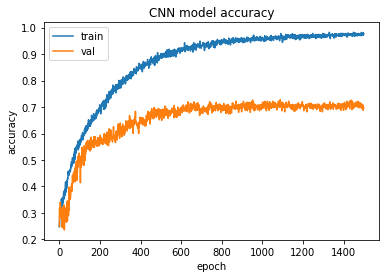

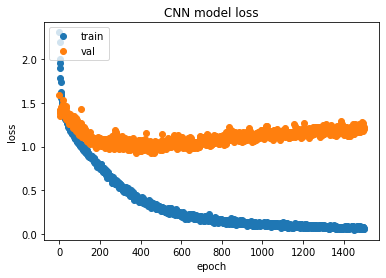

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN model

score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN model:',score[1])

Test accuracy of the CNN model: 0.6659142374992371


In [ ]:
# Model parameters
dropout = 0.5
lr = 1e-3
epochs = 1500
momentum = 0.9

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(1000,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
# optimizer = keras.optimizers.Adam(lr=learning_rate)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum, decay=1*10**(-3-(epochs%500)/2))

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

## shallow Conv

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 100

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 1000, 1, 32)       7072      
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 1000, 1, 32)       10272     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 334, 1, 32)        0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 334, 1, 32)        128       
_________________________________________________________________
dropout_98 (Dropout)         (None, 334, 1, 32)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 334, 1, 128)       41088     
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 334, 1, 128)     

KeyboardInterrupt: ignored

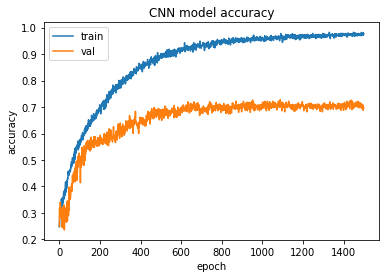

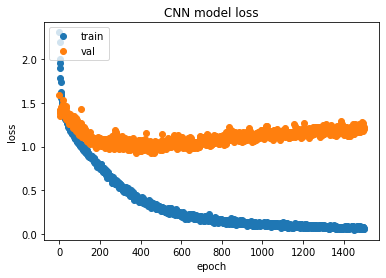

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

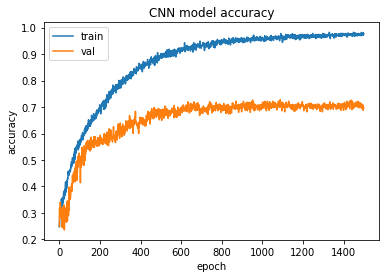

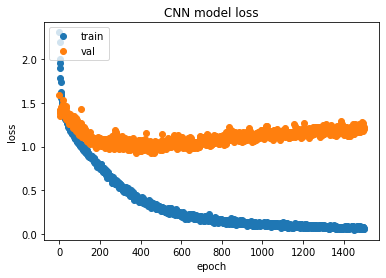

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Model parameters
dropout = 0.5
lr = 1e-4
epochs = 1500
momentum = 0.9

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(1000,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
# optimizer = keras.optimizers.Adam(lr=learning_rate)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_163 (Conv2D)          (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 334, 1, 25)        100       
_________________________________________________________________
dropout_109 (Dropout)        (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_110 (Bat (None, 112, 1, 50)      

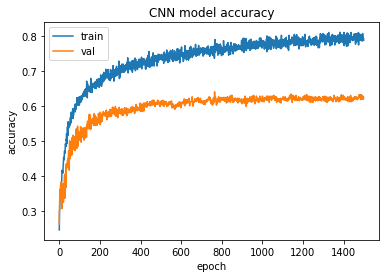

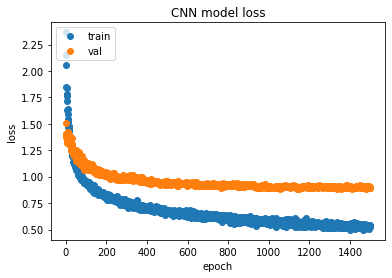

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the CNN model

score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN model:',score[1])

Test accuracy of the CNN model: 0.6320541501045227


## Baseline

In [ ]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 100

#Building the model

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
cnn_model.add(Conv2D(filters=2))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Printing the model summary
cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)